In [10]:
import string
import re
import pandas as pd
import collections
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as pl
from wordcloud import WordCloud
import pickle
from collections import Counter

In [11]:
# Read dataset
data = pd.read_csv('C:\\Users\\Wellery\\Desktop\\IMDB_dataset.csv', engine='python', error_bad_lines=False) 

# Print first 5 rows
for i in range(5):
    print(f"Review with {data.iloc[i]['sentiment'].upper()} sentiment:\n")
    print(data.iloc[i]['review'] + "\n")

Review with POSITIVE sentiment:

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main app

In [3]:
data.info

<bound method DataFrame.info of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

<BarContainer object of 2 artists>

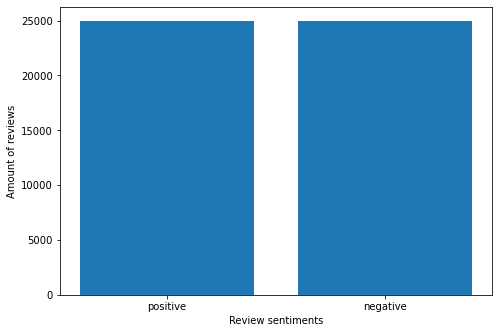

In [4]:
# Analyse how many reviews of each sentiment
fig = pl.figure()
ax = fig.add_axes([0,0,1,1])
x = ['positive', 'negative']
y = data['sentiment'].value_counts()
pl.ylabel('Amount of reviews')
pl.xlabel('Review sentiments')
ax.bar(x, y)

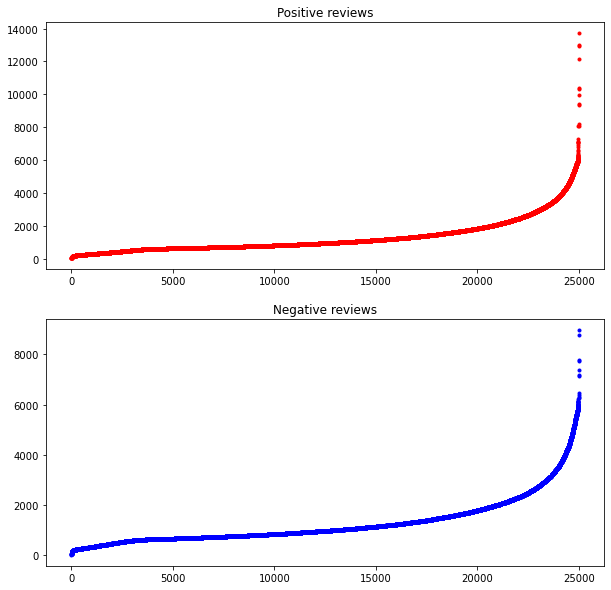

In [5]:
# Analyse uniformity of length of postive and negative reviews
review_len = []
for review in data['review']:
    review_len.append(len(review))
data['review_len'] = review_len

positive_data = data[data['sentiment'] == 'positive'].sort_values(by=['review_len'])
negative_data = data[data['sentiment'] == 'negative'].sort_values(by=['review_len'])

x_neg = range(0,25000)
y_neg = negative_data['review_len']

x_pos = range(0,25000)
y_pos = positive_data['review_len']

fig, (ax1, ax2) = pl.subplots(2, 1, figsize=(10,10))
ax1.set_title("Positive reviews")
ax1.plot(x_pos, y_pos, 'r.')
ax2.set_title('Negative reviews')
ax2.plot(x_neg, y_neg, 'b.')

In [19]:
# Add a new column. positive = 1; negative = 0
sentiment_bool = [0 if sentiment == 'negative' else 1 for sentiment in data['sentiment']]
data['sentiment_bool'] = sentiment_bool

In [14]:
# Cleaning of reviews

# Need improvments: 
# 1. Delete the most common neutral words (update: added into stopwords but maybe there are others)
#    Update: tried and it doesnt affect on accurancy
# 2. Check spelling (tried but make the process in three times slower)

stop_words = set(stopwords.words('english'))
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

filtered_review = []

def get_wordnet_pos(word):
    """Get wordnet pos (part of speech) tags."""
    
    # define extensive pos tag of the word (f.i. NNP - proper name)
    word_and_tag = pos_tag([word])[0]
    
    # get only tag (without word)
    tag = word_and_tag[1]
    
    # get only a short information (first letter) about part of speech (adj, noun, verb, adv)
    short_tag = tag[0]
    
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
    
for review in data['review']:
    # remove html tags and 
    review = re.sub("<.*?>", " ", review) 
    
    # remove punctuation and digits
    review = review.translate(str.maketrans(string.punctuation + string.digits, 42*' '))
    
    # tokenize via wordpsace and tabulations symbols + spelling correction
    review_tokens = tokenizer.tokenize(review)
    lower_review_tokens = [token.lower() for token in review_tokens]
    review_tokens = [token for token in lower_review_tokens if token not in stop_words]
    
    # lemmatize words (remove some suffixex, endings, plural forms,...)
    review_lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in review_tokens]
    
    filtered_review.append(review_lemmas)
    

data['filtered_review'] = filtered_review

In [18]:
# Vectorizing of reviews

# max amount of words in vocabulary
max_features = 5000
 
# ignore words with frequency higher than this threhold (proportion)
max_df = 0.8

vectorizer = TfidfVectorizer(max_features=max_features, max_df=max_df)
vocabulary = vectorizer.fit_transform([' '.join(review) for review in data['filtered_review']])

# Vectorized bool data
reviews_bool = vocabulary.toarray()

In [9]:
# Save vectorizer into the file
pickle.dump(vectorizer, open("C:\\Users\\Wellery\\Desktop\\vectorizer.pickle", "wb"))

In [20]:
# generate training and test data. Part of test data is 30% of the array
x_train, x_test, y_train, y_test = train_test_split(reviews_bool, data['sentiment_bool'], test_size=0.3, random_state=10, shuffle=True)

In [22]:
# train the model
text_classifier = SGDClassifier()
text_classifier.fit(x_train, y_train)
predictions = text_classifier.predict(x_test)

# results, check on test data
print(accuracy_score(y_test, predictions))

0.8838


In [24]:
# test the model on data for tranining
predictions_train = text_classifier.predict(x_train)

# results
print(accuracy_score(y_train, predictions_train))

0.9085428571428571


In [ ]:
# load the model from the file (example)
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)